# 결정트리, 교차검증 (Cross validation), 그리드서치 (Grid search)

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/5-2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

fpath = "../dataset"

In [3]:
## Wine data 분석

In [6]:
wine = pd.read_csv('https://bit.ly/wine-date')
wine.info()
wine.head()
wine["class"].value_counts()

wine["class"] = wine["class"].astype("int32").astype('category')
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   alcohol  6497 non-null   float64 
 1   sugar    6497 non-null   float64 
 2   pH       6497 non-null   float64 
 3   class    6497 non-null   category
dtypes: category(1), float64(3)
memory usage: 158.8 KB


In [7]:
## Summary statistic
wine_group = wine.groupby("class", observed=True)
list(wine_group)


for idx, data in wine_group:
    print("class = ", idx)
    print(data.describe())
    print("="*50)


class =  0
           alcohol        sugar           pH
count  1599.000000  1599.000000  1599.000000
mean     10.422983     2.538806     3.311113
std       1.065668     1.409928     0.154386
min       8.400000     0.900000     2.740000
25%       9.500000     1.900000     3.210000
50%      10.200000     2.200000     3.310000
75%      11.100000     2.600000     3.400000
max      14.900000    15.500000     4.010000
class =  1
           alcohol        sugar           pH
count  4898.000000  4898.000000  4898.000000
mean     10.514267     6.391415     3.188267
std       1.230621     5.072058     0.151001
min       8.000000     0.600000     2.720000
25%       9.500000     1.700000     3.090000
50%      10.400000     5.200000     3.180000
75%      11.400000     9.900000     3.280000
max      14.200000    65.800000     3.820000


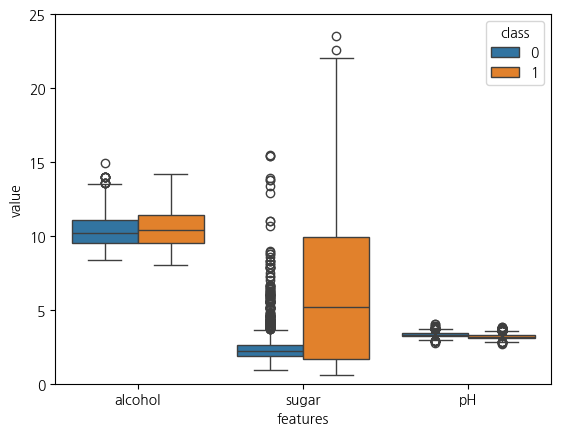

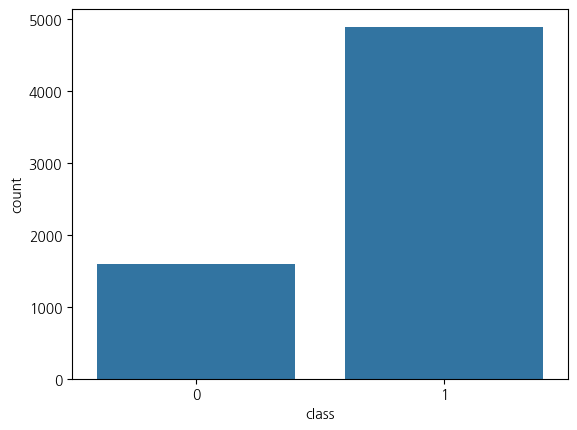

In [8]:
## Visualization
wine_long = pd.melt(wine, id_vars="class", var_name = "features", value_name="value")
wine_long
sns.boxplot(wine_long, x = "features", y = "value", hue = "class")
plt.ylim(0, 25)
plt.show()

sns.countplot(wine, x = 'class')
plt.show()

In [9]:
## Feature and target

data = wine[['alcohol', 'sugar', 'pH']]
target = wine['class']

print("data = \n", data.head())
print("target = \n", target.head())

data = 
    alcohol  sugar    pH
0      9.4    1.9  3.51
1      9.8    2.6  3.20
2      9.8    2.3  3.26
3      9.8    1.9  3.16
4      9.4    1.9  3.51
target = 
 0    0
1    0
2    0
3    0
4    0
Name: class, dtype: category
Categories (2, int32): [0, 1]


### Training 과 Validation dataset으로 분할

In [10]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = \
train_test_split(data, target, stratify=target, test_size =0.2,
                 random_state = 42)
print('train_input shape = ', train_input.shape)
print('test_input shape = ', test_input.shape)

train_input shape =  (5197, 3)
test_input shape =  (1300, 3)


### Z-transform

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(train_input)

print("scale mean = ", scaler.mean_)
print("scale std = ", scaler.scale_)
print("feature number = ", scaler.n_features_in_)

## Z-transform
train_scaled = scaler.transform(train_input)
test_scaled = scaler.transform(test_input)

print(train_input.head())
print(train_scaled[:10]) 

scale mean =  [10.48958309  5.39210121  3.21797576]
scale std =  [1.19457346 4.72528424 0.16013434]
feature number =  3
      alcohol  sugar    pH
4110      9.4   11.2  3.19
3062     11.0    1.2  3.06
5236     11.2    4.8  3.12
497      11.1    2.5  3.32
826      11.0    2.3  3.40
[[-0.91211058  1.22911099 -0.17470179]
 [ 0.42727963 -0.88716382 -0.98652017]
 [ 0.59470341 -0.12530489 -0.61183476]
 [ 0.51099152 -0.61204809  0.63711659]
 [ 0.42727963 -0.65437359  1.13669714]
 [-0.40983925 -0.76018733 -0.29959692]
 [-1.16324624  2.2449229  -0.86162503]
 [ 0.76212718 -0.90832657  0.57466903]
 [ 0.67841529 -0.90832657 -0.17470179]
 [ 0.67841529 -0.78135008 -0.48693963]]


In [30]:
from sklearn.tree import DecisionTreeClassifier

# Init signature:
# DecisionTreeClassifier(
#     *,
#     criterion='gini', The function to measure the quality of a split.
#     splitter='best',
#     max_depth=None, # controlled by min_sample_split
#     min_samples_split=2, # for an internal node
#     min_samples_leaf=1, # for a leaf node, training samples in each of the left and right branches. 
#     min_weight_fraction_leaf=0.0, weights are determined by sample_weight in the fit() method.
#     max_features=None, # `max_features=n_features`
#     random_state=None, #  When ``max_features < n_features` To obtain a deterministic behaviour
#     max_leaf_nodes=None, # To obtain a deterministic behaviour
#     min_impurity_decrease=0.0, # split, than or equal to this value.
#     class_weight=None,
#     ccp_alpha=0.0, # Cost-Complexity Pruning, min(SSE + ccp_alpha*|n of leaf node|)
# )

dt = DecisionTreeClassifier(criterion = 'gini', random_state=42)
dt.fit(train_input, train_target)

# Overfitting problem
print("Train accracy = ", dt.score(train_input, train_target))
print("Test accracy = ", dt.score(test_input, test_target))

Train accracy =  0.9978833942659227
Test accracy =  0.8653846153846154


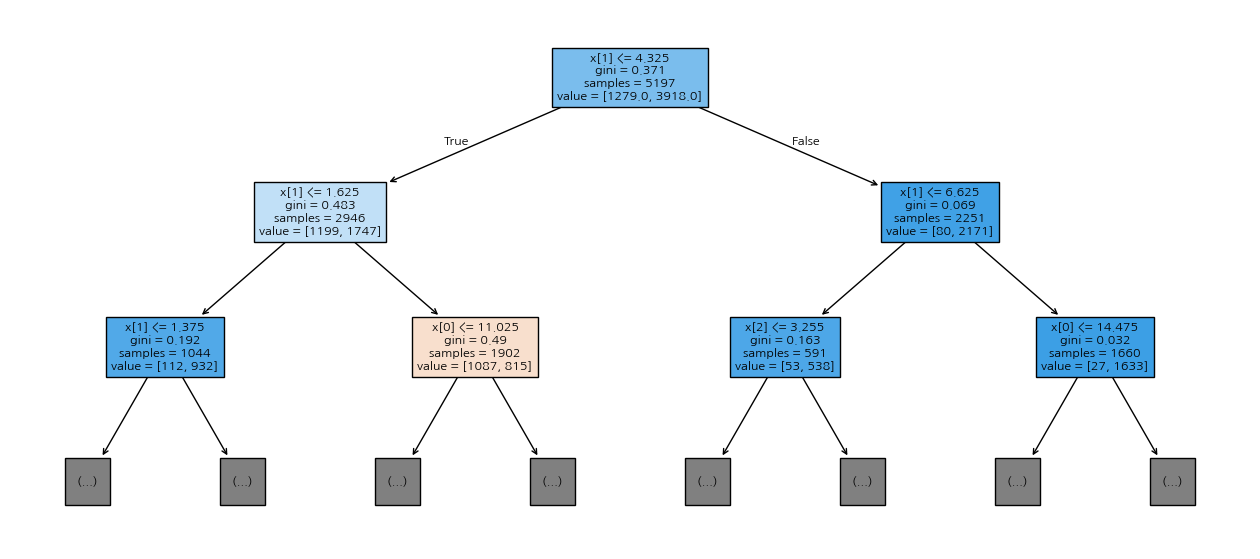

In [29]:
## Tree 그리기
from sklearn.tree import plot_tree
# figsize: Width, height in inches.
plt.figure(figsize=(16,7))
plot_tree(dt, max_depth= 2, filled=True)
plt.show()

### 가지치기 (Pruning)

In [33]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_input, train_target)

print("Train accracy = ", dt.score(train_input, train_target))
print("Test accracy = ", dt.score(test_input, test_target))

Train accracy =  0.8458726188185491
Test accracy =  0.8407692307692308


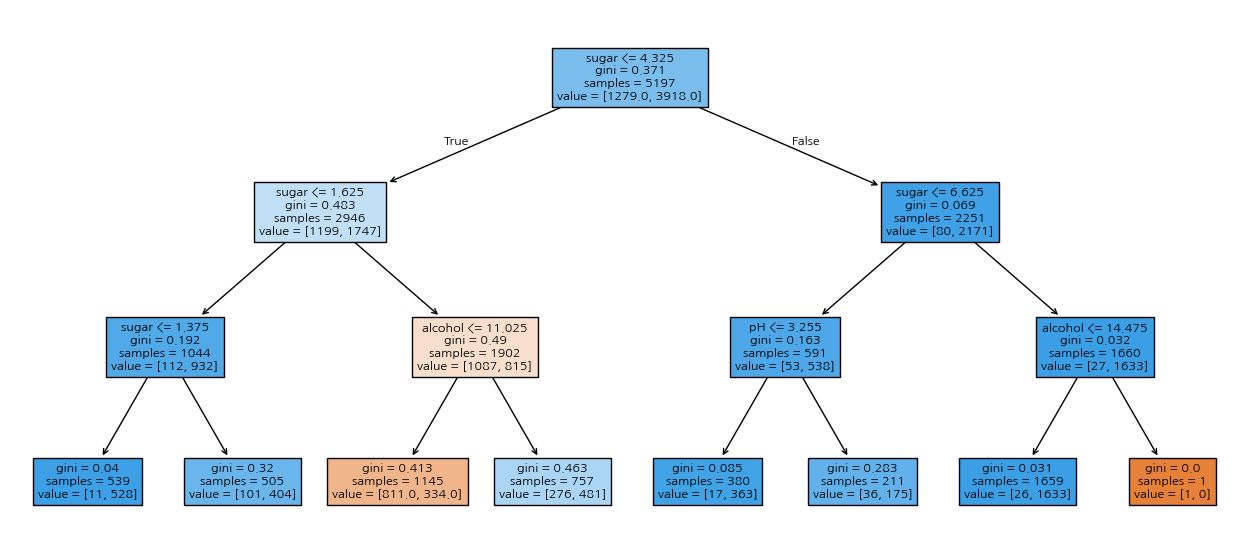

In [37]:
plt.figure(figsize=(16,7))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

### 변수의 중요도 (Feature importance)

In [36]:
## Return the feature importances (Ginni importance)
print(dt)
print(dt.feature_importances_)
print('변수의 중요도: alcohol = {0:.3f}, sugar = {1:.3f}, pH= {2:.3f}'. \
      format(dt.feature_importances_[0], dt.feature_importances_[1], dt.feature_importances_[2]))

DecisionTreeClassifier(max_depth=3, random_state=42)
[0.14086835 0.85360568 0.00552597]
변수의 중요도: alcohol = 0.141, sugar = 0.854, pH= 0.006


In [ ]:
## 문제
'''
Decision Tree 를 이용하여 Titanic data 생존자 분석
'''

## 교차 검증

In [11]:
# Evaluate metric(s) by cross-validation and also record fit/score times.
from sklearn.model_selection import cross_validate

# None, to use the default 5-fold cross validation,
cv_scores = cross_validate(dt, train_input, train_target, cv = 5)

print(cv_scores['test_score'])
# print(scores['test_score'].mean())

[0.88653846 0.86730769 0.85961538 0.88653846 0.84807692 0.85769231
 0.87884615 0.84971098 0.85163776 0.84393064]


In [38]:
# 분류모델의 경우 target class의 비율이 잘 유지 되도록
# The folds are made by preserving the percentage of samples for each class.

from sklearn.model_selection import StratifiedKFold

# whether to shuffle each class's samples before splitting into batches
# Note that the samples within each split will not be shuffled.
splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores['test_score']))

NameError: name 'cross_validate' is not defined

## 하이퍼파라미터 튜닝

In [13]:
from sklearn.model_selection import GridSearchCV

# params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}
params = {'max_depth': [2, 3, 4, 5, 6]}
# max_depth=3

In [16]:
### 25번의 교차검증을 실시
## 각 params, 5번의 cv 실시
## ``-1`` means using all processors
dt = DecisionTreeClassifier(random_state=42)

gs = GridSearchCV(estimator = dt, 
                  param_grid = params, 
                  cv = 5, n_jobs=-1)
gs.fit(train_input, train_target)

In [39]:
##최적의 모델 파라메터 저장한 모델
dt = gs.best_estimator_
print(dt.score(train_input, train_target))

NameError: name 'gs' is not defined

In [46]:
print(gs.best_params_)

{'max_depth': 5}


### 5번의 교차검증 결과 확인

In [47]:
print(gs.cv_results_['mean_test_score'])

[0.81393555 0.84125583 0.85337806 0.85780355 0.8558801 ]


In [48]:
best_index = np.argmax(gs.cv_results_['mean_test_score'])
print(best_index)

print(gs.cv_results_['params'][best_index])
# print(gs.cv_results_['params'][0])


3
{'max_depth': 5}


In [49]:
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          'max_depth': range(5, 20, 1),
          'min_samples_split': range(2, 100, 10)
          }

In [53]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)

gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [51]:
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


In [52]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


### 랜덤 서치
#### 매개변수로서 확률분포객체를 전달

In [53]:
from scipy.stats import uniform, randint
# from numpy.random import uniform, randint

In [55]:
# A uniform discrete random variable

# randint, A uniform discrete random variable.
rgen = randint(low = 0, high = 9)
rgen.rvs(5)

array([1, 7, 3, 6, 3])

In [56]:
# Find the unique elements of an array.
np.unique(rgen.rvs(1000), return_counts=True)
# np.unique(rgen.rvs(1000))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([105, 112, 120, 108, 115, 108, 106, 109, 117], dtype=int64))

In [57]:
# A uniform continuous random variable.
ugen = uniform(0, 1)
ugen
# ugen.rvs(10)

In [58]:
randint(20, 50)
uniform(0.0001, 0.001)

In [59]:
## 파라메터에 랜텀값 대신 random number generator class 를 넣어줌

params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25),
          }

In [60]:
# In contrast to GridSearchCV, not all parameter values are tried out, but
# rather a fixed number of parameter settings is sampled from the specified
# distributions

from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, 
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020049E40D60>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020049E33F10>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020049E40F10>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020049D7D310>},
                   random_state=42)

In [31]:
print(gs.best_params_)

{'max_depth': 26, 'min_impurity_decrease': 0.0002743664290049914, 'min_samples_leaf': 1, 'min_samples_split': 9}


In [77]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8695428296438884


In [78]:
dt = gs.best_estimator_

print(dt.score(test_input, test_target))

0.86


## 확인문제

In [ ]:
gs = RandomizedSearchCV(DecisionTreeClassifier(splitter='random', random_state=42), params, 
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=42,
         

In [ ]:
print(gs.best_params_)
print(np.max(gs.cv_results_['mean_test_score']))

dt = gs.best_estimator_
print(dt.score(test_input, test_target))

{'max_depth': 43, 'min_impurity_decrease': 0.00011407982271508446, 'min_samples_leaf': 19, 'min_samples_split': 18}
0.8458726956392981
0.786923076923077
